# Class 4: Scraping Web Data 1 - BeautifulSoup, HTML, and a Network


## How do websites work?

### What is the "backend" of a website?
The backend of a website has a bunch of moving parts. Content probably lives in a database (or, more likely these days, several databases). There are servers (big computers) with functions that are responsible for getting content from the databases and sending it, in a machine-readable format, to the frontend. This functionality is called an API, or *Application Programming Interface*. It is (generally speaking) how computers request and get data. 

### What is the "frontend" of a website?
The frontend of a website is where you, the human user, see the content. The frontend takes the big chunk of content sent from the server via the API and puts it into a nice, pretty format. This is what you see as "the website." The way that websites typically display content is via a combination of HTML (hypertext markup language) and Javascript, for the interactive features. 
#### HTML
HTML is a programming language that people use to make webpages. It consists of *elements* that can be nested within each other. Elements are indicated with *tags;* typically there are open tags (`<p>`) and close tags (`</p>`) that surround the contents of an element. Browsers read HTML and use the tags to figure out how to display content; you don't see the raw HTML when you use a browser (though you can do so using the "inspect element" feature). Here is an example of a (very bare-bones) HTML file:
```
<!DOCTYPE html>
<html>
<head>This is a header!</head>
<body>

<h1>This is a heading!</h1>

<p>And this is a paragraph</p>

</body>
</html>
```
Let's see what this looks like in our notebook!

In [5]:
from IPython.core.display import display, HTML

my_html_string = """
<!DOCTYPE html>
<html>
<head>This is a header!</head>
<body>

<h1>This is a heading!</h1>

<p>And this is a paragraph</p>

</body>
</html>
"""
display(HTML(my_html_string))

Here's an example with a link and an image:

In [13]:
now_with_link = """
<!DOCTYPE html>
<html>
<head>This has a link!</head>
<p>
<a href="https://northeastern.edu">This is a link</a>
</p>
<img src="images/whale.jpg" alt="this is a whale" width=200 height=200>
"""
display(HTML(now_with_link))

Obviously most websites are more fancy than that, but at their core, when you visit them, HTML is being generated -- and you can look at it with your computer instead of via your browser. 
The act of looking at web pages via your computer (i.e. programatically) instead of via a conventional browser is called *scraping*, and it's not super hard to do!

## Ways to access a website
### Visiting the website via a browser 
Pros: 
* Does not require that much specialized knowledge.
* Is how you're generally encouraged to use websites.
* Easy to understand what you're looking at.

Cons:
* Does not scale well (if you're trying to look at 5000 webpages, this is not a good approach)

### Using a website's API
Pros:
* Much faster
* Scales better
* Output is easily machine-readable

Cons:
* The API exists because the website's owner allows it to exist (see: Twitter/X). 
* Might cost money
* Might have rate limits
* Output is not easy to read if you are a human

### Scraping a website
Pros:
* Also scales pretty well
* Does not require the goodwill of a website's owner
* Scraping publicly accessible data is [legal](https://techcrunch.com/2022/04/18/web-scraping-legal-court/) in the US

Cons:
* You run the risk of getting your IP banned
* Often have to build a custom scraper for each website
* Not doable for all websites (e.g. Facebook)

## How do we scrape a website?

### First, we practice good robot citizenship via the `robots.txt` file!
https://en.wikipedia.org/wiki/Robots_exclusion_standard

http://www.robotstxt.org/robotstxt.html

- It is a standard used by websites to communicate with web crawlers and other web robots
- The standard specifies how to inform the web robot about which areas of the website should not be processed or scanned
- Robots are often used by search engines to categorize web sites
- Not all robots cooperate with the standard; email harvesters, spambots, malware, and robots that scan for security vulnerabilities may even start with the portions of the website where they have been told to stay out

In practice,
- when a site owner wishes to give instructions to web robots they place a text file called robots.txt in the root of the web site hierarchy (e.g. https://www.example.com/robots.txt)
- this text file contains the instructions in a specific format
- robots that choose to follow the instructions try to fetch this file and read the instructions before fetching any other file from the web site
- if this file doesn't exist, web robots assume that the web owner wishes to provide no specific instructions, and crawl the entire site.
- a robots.txt file covers one origin. For websites with multiple subdomains, each subdomain must have its own robots.txt file.

### Let's check out the `robots.txt` for tmz.com using the `requests` package.
The `requests` package lets us make requests to websites or APIs. It gives us back HTML webpages that we can read through as if they were .html files. 

In [15]:
import requests
res = requests.get('https://www.tmz.com/robots.txt')
print(res.text)

Sitemap: https://www.tmz.com/sitemaps/article/index.xml
Sitemap: https://www.tmz.com/sitemaps/gallery/index.xml
Sitemap: https://www.tmz.com/sitemaps/page/index.xml
Sitemap: https://www.tmz.com/sitemaps/watch/index.xml
Sitemap: https://www.tmz.com/sitemaps/news.xml

User-agent: Googlebot-News
Disallow: /photos
Disallow: /videos

User-agent: proximic
Disallow:

User-agent: bingbot
Crawl-delay: 60

User-agent: *

Disallow: /_/
Disallow: */print
Disallow: /search
Disallow: /xid




Our `User-agent` is categorized under `*` because it is not Googlebot_news, proximic, or bingbot. This means we're not allowed to go to `tmz.com/*/print`, `tmz.com/search/`, or `tmz.com/xid`. 

## Actually Scraping Data
Now, a fun exercise. We've used [`mediacloud.org`](https://www.mediacloud.org/documentation/search-api-guide) to obtain the URLs of all articles about the KarJenners (Kardashians & Jenners) from January 1st, 2024 until July 30, 2024. We'll load the article URLs and gradually construct a name co-occurrence network from a random subset of articles. Let's load the `.csv` of articles first.

In [23]:
import csv
with open('data/kardashian_jenner_urls_jan_1_2024_to_july_31_2024_mediacloud.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    urls = [line[-1] for line in reader][1:]
print(urls[0:5])

['https://www.tmz.com/2024/07/30/eminem-death-slim-shady-ai-interview-mgk-mother/', 'https://www.tmz.com/2024/07/29/khloe-kardashian-dinosaur-tatum-birthday-party-kris-kim/', 'https://www.tmz.com/2024/07/29/travis-barker-selling-post-crash-boarding-pass-personal-note/', 'https://www.tmz.com/2024/07/28/july-2024-hot-shots-dog-days-of-summer-will-have-you-panting/', 'https://www.tmz.com/2024/07/28/kanye-west-bianca-censori-tiny-shorts-take-north-west-deadpool/']


### Let's scrape an article! 
To make it fun, we'll each pick a random article to scrape and parse. We're going to use the `BeautifulSoup` python package to parse the HTML that we'll get via our `requests` module. 

In [71]:
from bs4 import BeautifulSoup
import random
my_url = random.choice(urls)
res = requests.get(my_url)
soup = BeautifulSoup(res.text)

Let's print out the soup. This will show us what the raw HTML looks like, and disincentivize us from ever writing our own HTML parsers! Note that there are a lot of Javascript scripts in there, denoted with `<script>` tags; these are often widgets or tracking features. 

In [72]:
soup

<!DOCTYPE html>
<html class="device-view-desktop viewer-country-us" data-device-view="desktop" data-env="prod" data-viewer-country="US" lang="es">
<!--
app_version=3.21.4
benchmark=111ms
etag=6bae834497d446c7bac2ee9023202daa
timestamp=1722462413
timestamp_iso=2024-07-31T21:46:53.903077Z
screen=desktop-article
-->
<head>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="en" http-equiv="content-language"/>
<meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1,minimum-scale=0.25,maximum-scale=10" name="viewport"/>
<meta content="unsafe-url" name="referrer"/>
<title>Bianca Censori se viste con pieles para cenar con Kanye y North West</title>
<link href="/rss.xml" rel="alternate" title="Celebrity Gossip | Entertainment News | Celebrity News | TMZ.com" type="application/rss+xml"/>
<meta content="UUmtbUBf3djgPpCeLefe_PbFsOc6JGxfXmHzpjFLAEQ" name="google-site-verification"/>
<m

The neat part of BeautifulSoup is that we can search for specific tags in the HTML. In this case, we're hunting for `<p>` tags, which will contain the actual article text. Within the article text, if someone is an important celebrity or if they refer to another article, TMZ will link to the relevant TMZ page using a `<a>` tag. Let's hunt for these links: 

In [73]:
for text_line in soup.find_all('p'):
    a_tags = text_line.find_all('a')
    print(a_tags)
    

[<a href="https://www.tmz.com/people/kanye-west/"><strong>Kanye West</strong></a>, <a href="https://www.tmz.com/people/bianca-censori/"><strong>Bianca Censori-,</strong></a>, <a href="https://www.tmz.com/people/north-west/"><strong>North West.</strong></a>]
[]
[]
[]
[<a href="https://www.tmz.com/2024/03/20/kanye-west-bianca-censori-lunch-cheesecake-factory-the-grove/"><strong>comer a Cheesecake Factory en The Grove </strong></a>]
[]
[<a href="https://www.tmz.com/people/kim-kardashian/"><strong>Kim Kardashian</strong></a>, <a href="https://www.tmz.com/2024/03/13/kim-kardashian-listening-party-bianca-censori-kanye-west-new-album-vultures/"><strong>interactuado con Bianca</strong></a>]
[]
[<a class="js-track-link" data-context='{"section":"footer-subscribe","name":"privacy-policy"}' href="https://www.tmz.com/es/privacy" rel="noopener noreferrer" target="_blank">política de privacidad</a>, <a class="js-track-link" data-context='{"section":"footer-subscribe","name":"privacy-policy"}' href="

Let's say we just want the pages that correspond to people. These pages' URLs have the pattern `https://www.tmz.com/people/NAME`. We can use this pattern to filter out other pages, then use string manipulation to grab just the person's name:

In [74]:
people_in_article = []
for text_line in soup.find_all('p'):
    a_tags = text_line.find_all('a')
    for tag in a_tags:
        href = tag.get('href')
        if 'https://www.tmz.com/people/' in href:
            people_in_article.append(href.split('/')[-2])


In [75]:
people_in_article

['kanye-west', 'bianca-censori', 'north-west', 'kim-kardashian']

Let's put this all together to make a function that takes in an article URL and returns a list of the people whose pages were linked in the article. 

In [105]:
# Your Turn!
def get_people_in_article(url):
    """
    Given a URL (string) of a TMZ article, 
    return a list of the names of the people (as strings) whose TMZ pages are linked in the article. 
    """
    pass

### Being Considerate While Scraping
In order to be considerate scrapers, we do our best to not overload the website. This means we wait for 5 or so seconds, if not longer, between requests. We also don't scrape too much data; to start, I'll ask you to scrape 30 articles randomly chosen from our list of 330 URLs.  

In [84]:
import time
lists_of_people = []
for url in random.sample(urls, 30):
    print(url)
    lists_of_people.append(get_people_in_article(url))
    time.sleep(7)

https://www.tmz.com/2024/06/25/ariana-grande-jeffrey-dahmer-dream-dinner-guest-sparks-backlash/
https://www.tmz.com/2024/06/23/tmz-tv-hot-takes-stormy-daniels-trump-stand-up-jokes-kourtney-kardashian-travis-barker-sex-story-conor-mcgregor-injury/
https://www.tmz.com/2024/02/27/kourtney-kardashian-supplement-lemme-facility-truck-robbed-ransom-note/
https://www.tmz.com/2024/04/07/kim-kardashian-bianca-censori-kourtney-khloe-vacay-sisters/
https://www.tmz.com/2024/03/15/kim-kardashian-attend-kanye-west-rolling-loud-bianca-censori-north/
https://www.tmz.com/2024/01/13/hot-babes-cold-snow-guess-who/
https://www.tmz.com/2024/01/18/kim-kardashian-se-suma-a-la-moda-de-los-videos-of-course-y-da-un-tour-por-su-oficina/
https://www.tmz.com/2024/05/19/kylie-jenner-son-aire-enjoy-date-monster-truck-rally/
https://www.tmz.com/2024/02/14/kourtney-kardashian-y-travis-barker-revelan-que-su-bebe-rocky-fue-concebido-en-san-valentin/
https://www.tmz.com/2024/03/26/ridley-scott-caught-in-frustration-amid-r

## Sidebar: Linux Screen
You may have run into problems where you are trying to run some code, but it takes a while to run. You want to leave your computer and go do other things, or your computer shuts down in the middle of the night while your code is running. Enter [`screen`](https://linuxhandbook.com/screen-command/). `screen` is a program that's on most Linux/Mac machines. It allows you to open up a new terminal window within `screen`, start running your code, and then close the terminal window *with the code still running*. You can log out of the server you're on, go about your day, and open up the `screen` session again to see how your code is doing. 

### Making a script & saving data
First, let's make a `.py` script to pull down the lists of people mentioned in the same TMZ articles. We'll save the list as a `pickle` file:
```
import pickle
f = some_object
pickle.dump(f, open('name_of_variable.pkl', 'wb'))
```
`pickle` is a Python package that is useful for saving and loading objects. It turns Python objects into files  that you can later load into the same object. Please don't use it for data that you're sharing widely with others, intend to persist for years, or for very large data; in all of these cases, things can go wrong and make your life difficult. Better formats are databases, `.csv` or `.tsv` files, or specific, more standardized formats like `.gexf` or `.gml` for networks. Once you have saved your `.py` script somewhere on Discovery, we can move on to practicing opening and closing a `screen` session. 

### Using `screen`
You open a screen using the command `screen -R SCREEN_NAME`. Name your screen something useful that you'll remember later; if you have multiple sessions going at once, you'll want to know which session is doing which task. Once in the screen session, you can treat it as a normal terminal session. Let's start running our Python script within the screen session, then detach from the screen. To detach from a screen session, we type CTRL-A and then d (for "detach"). 

Now let's list our active screen sessions using `screen -list`. Your screen session should pop up here! To resume your screen session, you can type `screen -R SCREEN_NAME` -- the `-R` stands for "resume." If you want to kill (end) a screen session, you can type CTRL-A and then k (for "kill"). Don't do this yet - we're still waiting for our code to run! 

While we wait for our code to run, let's switch back to our notebook and practice constructing a network from the data we already have.

## Constructing a Network from Scraped Data
Next, we're going to construct a network from our scraped data. How? We're going to put a link between people who are mentioned in the same article. First, we'll build an unweighted network. We'll need to create a blank `networkx` `Graph` object and iterate over each list of people. For each list of people, we'll need to make sure that we get rid of duplicate mentions and then link everyone who is mentioned in the same article (no self links please!)

In [87]:
import networkx as nx

unweighted_g = nx.Graph()

# Your turn: build a graph that links people mentioned in the same article!

### What can we do with our network?
Let's think about what we can learn from our network. One way to figure out who the important players in a particular network is called *k-core decomposition*. In plain terms, obtaining the [*k-core*](https://www.baeldung.com/cs/graph-k-core) of a graph for a particular value of *k* means we look at all the nodes in our network. If their degree is greater than or equal to *k*, we keep them. Otherwise, we remove them. 

### Interactive Moment
What do you think the k-core of the TMZ mention network made of articles about the Kardashian/Jenner family will tell us about the Kardashain/Jenner family?

### K-core size
First, let's plot the size of the k-core of this network as *k* increases.

Text(0.5, 1.0, 'K-core size of Kardashian/Jenner TMZ Mention Network')

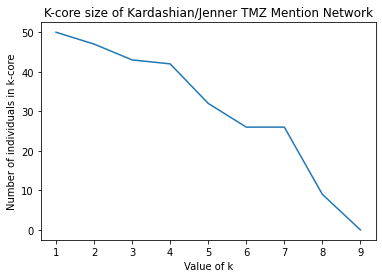

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
n_in_k_core = []
for k in range(1, 10):
    n_in_k_core.append(len(nx.k_core(unweighted_g, k)))
plt.plot([k for k in range(1, 10)], n_in_k_core)
plt.xlabel('Value of k')
plt.ylabel('Number of individuals in k-core')
plt.title('K-core size of Kardashian/Jenner TMZ Mention Network')

### Fun Activity
How would you answer these questions, using your TMZ mention network and k-core decomposition?
* Who is most important to the Kardashian/Jenner family? 
* Who is least important? 

In [102]:
# Your Turn!

### Another Fun Activity
Try to figure out the following exercises:
* Can you figure out who are the highest-degree nodes in your network? Are there any that are surprising?
* Compare your results with the results from the scraping run you did in your `screen` session. What's similar? What's different?

In [104]:
# Your Turn!

### REMINDER: Remember to save your networks in a usable format - you will need them for the homework!